# Estimate ATE with bias correction using simulated data

In this notebook, I sample a training dataset according to the following DAG:

![DAG](<simulations_with_bias_correction_dag.png>)

In this setup, $C$ is a confounder that influences both the treatment assignment $T$ and the outcome $Y$, and is sampled from a standard normal distribution, $C \sim \mathcal{N}(0, 1)$. Treatment is assigned probabilistically based on $C$ using a sigmoid function:

\begin{equation}
    T \sim \text{Bernoulli}\left( \frac{1}{1 + \exp(-C)} \right)
\end{equation}

The outcome $Y$ is then generated as:

$$
Y \sim \mathcal{N}(\tau T + C, \sigma_Y)
$$

This formulation implies that higher values of $C$ both increase the likelihood of treatment and the expected outcome.

To emulate a real-world scenario where outcomes are not directly observed but inferred from complex data (e.g., satellite imagery), we construct a latent representation $X = g(Y)$. Here, $g$ is a randomly initialized three-layer neural network with ReLU activations. The network takes scalar $Y$ as input, processes it through hidden layers of dimension 50, and outputs a 100-dimensional embedding $X$.

A separate model $f$ is then trained to predict the outcome $Y$ from the embedding $X$. The resulting predictions $\hat{Y} = f(X)$ are used to estimate the treatment effect $\tau$ via Inverse Probability of Treatment Weighting (IPTW) with the treatment probability given as in (1).

To compare the different debiasing approaches, the IPTW estimates were done for different predicted values.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here, I define $g$ as a randomly initialized three-layer neural network with ReLU activations. The network takes scalar $Y$ as input, processes it through hidden layers of dimension 50, and outputs a 100-dimensional embedding $X$.

In [2]:
class EmbeddingGenerator(nn.Module):
    def __init__(self, input_dim=1, n_layers=4, hidden_dim=50, embedding_dim=100, device='cuda'):
        super(EmbeddingGenerator, self).__init__()

        self.device = device

        layers = []
        for i in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(hidden_dim, embedding_dim))

        self.model = nn.Sequential(*layers)
        self.model.to(self.device)

        # Freeze weights
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x.cpu().numpy()

emb_model = EmbeddingGenerator(input_dim=1)
emb_model

EmbeddingGenerator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=50, out_features=100, bias=True)
  )
)

Sample a population using the DAG outlined above

In [3]:
def generate_population(g_func, n_samples=10000, tau=2.0, alpha=1.0, sigma_Y=1.0, sigma_X=0.5, seed=42):
    """
    Generates a synthetic population for causal inference simulations.

    Parameters:
    g_func (function): A function that takes Y as input and returns a proxy X.
    n_samples (int, optional): Number of samples to generate. Default is 10000.
    tau (float, optional): True Average Treatment Effect (ATE) of treatment T. Default is 2.0.
    alpha (float, optional): Effect of confounder C on outcome Y. Default is 1.0.
    sigma_Y (float, optional): Standard deviation of noise in outcome Y. Default is 1.0.
    sigma_X (float, optional): Standard deviation of noise in proxy X. Default is 0.5.
    seed (int, optional): Random seed for reproducibility. Default is 42.

    Returns:
    pd.DataFrame: A DataFrame containing the generated population with columns:
        - 'C': Confounder values.
        - 'T': Treatment assignment.
        - 'Y': Outcome values.
        - 'p_T_given_C': Probability of treatment given confounder C.
        - 'X': Proxy values for outcome Y.
    """

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate confounder C ~ N(0, 1)
    C = np.random.normal(0, 1, n_samples)

    # Generate treatment T ~ Bernoulli(p(C)) where p(C) is a logistic function of C
    p_T_given_C = 1 / (1 + np.exp(-C))  # Logistic function
    T = np.random.binomial(1, p_T_given_C, n_samples)

    # Generate outcome Y ~ N(tau * T + alpha * C, sigma_Y)
    Y = tau * T + alpha * C + np.random.normal(0, sigma_Y, n_samples)

    # Generate proxy X = g_func(Y) + noise
    X = g_func(Y)
    X += np.random.normal(0, sigma_X, X.shape)

    population = pd.DataFrame({
        'C': C,
        'T': T,
        'Y': Y,
        'p_T_given_C': p_T_given_C,
        'X': list(X)
    })

    return population

Utility code for training the model $f$ and plotting the results. TODO: Move to separate file

In [4]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim=100, size='M'):
        super(RegressionModel, self).__init__()
        
        if size == 'S':
            self.fc = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        elif size == 'M':
            self.fc = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        elif size == 'L':
            self.fc = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
    
    def forward(self, x):
        return self.fc(x).squeeze()

def plot_history(train_history, val_history, model_name=None):
    
    loss_types = train_history[0].keys()
    
    train_his_df = pd.DataFrame(train_history)
    train_his_df['Epoch'] = train_his_df.index
    train_his_df['Set'] = 'Training'

    val_his_df = pd.DataFrame(val_history)
    val_his_df['Epoch'] = val_his_df.index
    val_his_df['Set'] = 'Validation'

    history_df = pd.concat([train_his_df, val_his_df], ignore_index=True)
    
    title = 'Losses during Training and Validation'
    if model_name:
        title = title + ' of ' + model_name
    
    n_losses = len(loss_types)
    
    if n_losses > 1:
        fig, axs = plt.subplots(1, n_losses, figsize=(18, 5))
        
        for i, loss_type in enumerate(loss_types):
            sns.lineplot(data=history_df, x='Epoch', y=loss_type, hue='Set', ax=axs[i])
            
        fig.suptitle(title, fontsize=16)
        plt.subplots_adjust(top=0.85)
        plt.tight_layout()
        plt.show()
    else:
        loss_type = next(iter(loss_types))
        sns.lineplot(data=history_df, x='Epoch', y=loss_type, hue='Set')
        plt.title(title)
        plt.show()

def train_model(M_train, M_val, y_train, y_val, loss_fn, lr=1e-3, l2=1e-5, base_model=None, model_size='M', model_name=None, verbose=1):
    
    torch.manual_seed(RANDOM_STATE)

    # Instantiate model
    main_model = base_model if base_model else RegressionModel(size=model_size).cuda()

    # Optimizer
    main_optimizer = optim.Adam(main_model.parameters(), lr=lr, weight_decay=l2)
    
    train_history = []
    val_history = []
    
    best_model = main_model.state_dict()
    best_loss = np.inf
    best_epoch = 0
    
    # Training loop
    max_epochs = 50000
    for epoch in tqdm(range(max_epochs), disable=verbose<1):

        # Train main model
        main_optimizer.zero_grad()
        y_pred = main_model(M_train)
        loss, log_object = loss_fn(y_pred, y_train)
        loss.backward()
        main_optimizer.step()
        
        train_history.append(log_object)
        
        with torch.no_grad():
            y_pred = main_model(M_val)
            loss, log_object = loss_fn(y_pred, y_val)
        
            val_history.append(log_object)
            
            # Save best model
            if loss < best_loss:
                best_model = main_model.state_dict()
                best_loss = loss.item()
                best_epoch = epoch
            
            # Early stopping
            if epoch - best_epoch > 200:
                break
                
    if best_epoch == epoch:
        print('Terminated before early stopping.')
            
    if verbose:
        plot_history(train_history, val_history, model_name)
    
    # Load best model
    main_model.load_state_dict(best_model)
    return main_model

# ================ Metrics ==================
    
def get_slope_model(targets, predictions):
    
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    slope_model = LinearRegression().fit(targets.reshape(-1, 1), predictions)
    
    return slope_model

def parity_plot(targets, predictions, title=None, ax=None):
    slope_model = get_slope_model(targets, predictions)
    
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()
    should_plot = False

    # Create a new figure and axis if none is provided
    if ax is None:
        should_plot = True
        fig, ax = plt.subplots()

    ax.scatter(targets, predictions, alpha=0.2)

    # Plot regression lines
    x = np.asarray([min(targets), max(targets)])
    ideal_y = x
    true_y = slope_model.predict(x.reshape(-1, 1))

    # Compute statistics and format the string
    stats_text = f'k={slope_model.coef_[0]:.2f}, r2={r2_score(targets, predictions):.2f}'

    ax.plot(x, ideal_y, 'k--', label='Ideal')
    ax.plot(x, true_y, c=sns.color_palette()[1], label='Fitted')
    ax.set_xlabel('Targets')
    ax.set_ylabel('Predictions')
    ax.set_title(title)
    ax.legend()

    # Add the text in the bottom-right corner
    ax.set_aspect('equal', adjustable='box')
    ax.set_box_aspect(1)  # Ensure the box is square
    ax.text(
        0.95, 0.05, stats_text,
        transform=ax.transAxes,
        fontsize=10, color='black', ha='right', va='bottom'
    )

    # Show the plot if no external axis was provided
    if should_plot:
        plt.show()
    
def resid_plot(targets, predictions, title, ax=None):
    
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()
    should_plot = False

    # Create a new figure and axis if none is provided
    if ax is None:
        should_plot = True
        fig, ax = plt.subplots()

    ax.scatter(targets, (targets - predictions), alpha=0.2)
    ax.axhline(0, ls=":", c=".2")
    ax.set_xlabel('Targets')
    ax.set_ylabel('Residuals')
    ax.set_title(title)

    if should_plot:
        plt.show()
        
        
def plot_results(targets, predictions, model_name):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    
    parity_plot(targets, predictions, title=f'Parity plot of {model_name}', ax=ax0)
    resid_plot(targets, predictions, f'Residuals of {model_name}', ax=ax1)
    fig.show()

Generate a training population and split into a training and a validation set

In [5]:
population = generate_population(emb_model, n_samples=10000, tau=2.0, alpha=1.0, sigma_Y=1.0, sigma_X=0.3, seed=RANDOM_STATE)

X = np.stack(population['X'].values)

scaler = StandardScaler()
X = scaler.fit_transform(X)

Y = population['Y'].values

X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

Train a neural network model $f$ to estimate $Y$ from $X$ with MSE.

 16%|█▋        | 8193/50000 [00:16<01:23, 500.05it/s]


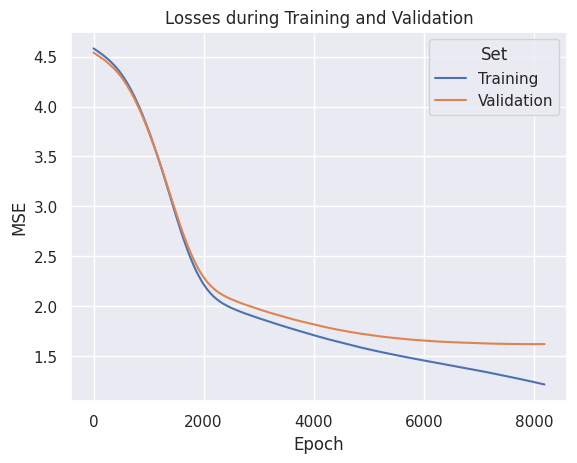

In [6]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-5, l2=1e-2, loss_fn=mse_loss, verbose=1)

Generate a test set using the same DAG and parameters to simulate fresh data. This is the set that we will use to estimate the ATE.

In [7]:
test_population = generate_population(emb_model, n_samples=10000, tau=2.0, alpha=1.0, sigma_Y=1.0, sigma_X=0.3, seed=RANDOM_STATE+1)

X_test = np.stack(test_population['X'].values)

X_test = scaler.transform(X_test)

Y_test = test_population['Y'].values

X_test = torch.tensor(X_test, dtype=torch.float).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float).to(device)

Plot how well the trained model $f$ works on the test set

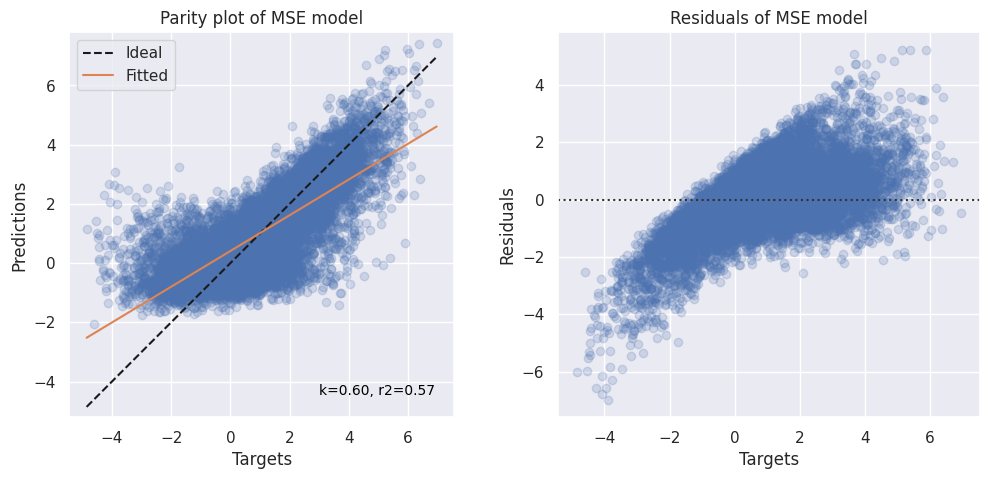

In [8]:
with torch.no_grad():
    y_pred = mse_model(X_test)
    
plot_results(Y_test, y_pred, 'MSE model')

Estimate $\tau$ using the target values $Y$ from the sample (Sample ATE) and the predicted values $\hat{Y}$ from the model $f$ (Predicted Sample ATE). As expected, the value based on $\hat{Y}$ is lower than the one based on $Y$.

In [9]:
predictions = y_pred.cpu().numpy()
targets = Y_test.cpu().numpy()
treatment_status = test_population['T']
propensity_score = test_population['p_T_given_C'].values

def calculate_ate_iptw(labels, treatment_status, propensity_score):
    """
    Calculate Average Treatment Effect (ATE) using IPTW.

    Parameters:
    - labels: numpy array of observed outcomes (Y)
    - treatment_status: numpy array of treatment assignment (T, binary: 1/0)
    - propensity_score: numpy array of propensity scores (e)

    Returns:
    - ATE (float)
    """

    # Avoid division by zero by clipping the propensity scores
    epsilon = 1e-6
    propensity_score = np.clip(propensity_score, epsilon, 1 - epsilon)

    # Calculate weights
    treated_weights = treatment_status / propensity_score
    control_weights = (1 - treatment_status) / (1 - propensity_score)

    # Compute the weighted outcomes
    treated_outcomes = treated_weights * labels
    control_outcomes = control_weights * labels

    # Estimate ATE
    ate = np.mean(treated_outcomes - control_outcomes)

    return ate

sample_ate = calculate_ate_iptw(targets, treatment_status, propensity_score)
predicted_sample_ate = calculate_ate_iptw(predictions, treatment_status, propensity_score)

print(f"Sample ATE: {sample_ate:.4f}")
print(f"Predicted Sample ATE: {predicted_sample_ate:.4f}")


Sample ATE: 1.9780
Predicted Sample ATE: 1.2474


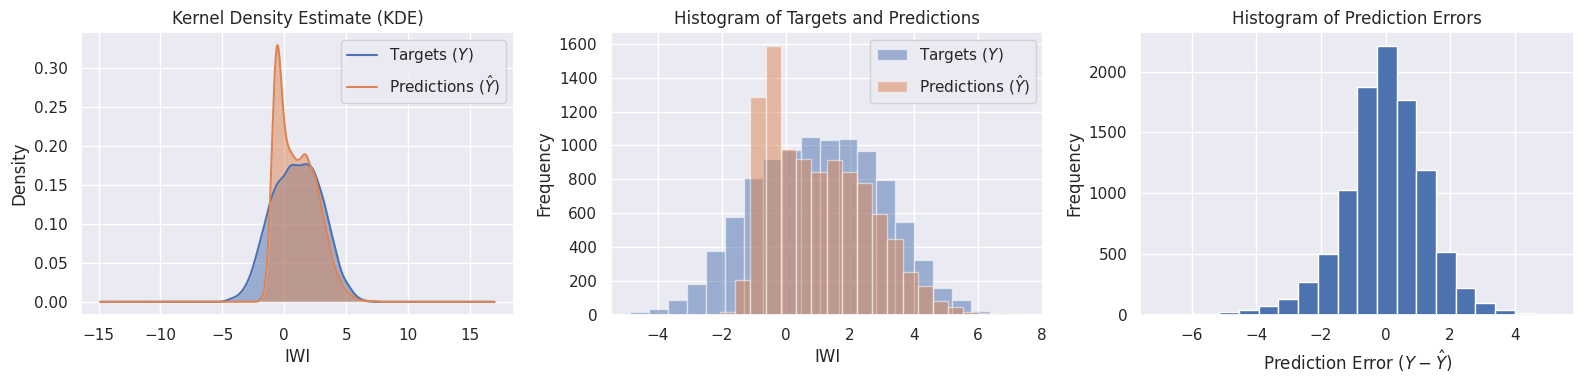

In [10]:
# Create KDE for marginal density p_Y(y)
target_kde = gaussian_kde(targets)
pred_kde = gaussian_kde(predictions)

# Create a range of x values to evaluate the KDE over
y_values = np.linspace(min(targets)-10, max(targets)+10, 1000)

# Evaluate the KDE over these x values
target_kde_values = target_kde(y_values)
pred_kde_values = pred_kde(y_values)

plt.figure(figsize=(16, 4))

# Plot the KDE
plt.subplot(1, 3, 1)
plt.plot(y_values, target_kde_values, label="Targets ($Y$)")
plt.fill_between(y_values, target_kde_values, alpha=0.5)
plt.plot(y_values, pred_kde_values, label="Predictions $(\hat{Y})$")
plt.fill_between(y_values, pred_kde_values, alpha=0.5)
plt.title("Kernel Density Estimate (KDE)")
plt.xlabel("IWI")
plt.ylabel("Density")
plt.legend()

# Plot histogram of targets and predictions
plt.subplot(1, 3, 2)
plt.hist(targets, bins=20, alpha=0.5, label="Targets ($Y$)")
plt.hist(predictions, bins=20, alpha=0.5, label="Predictions $(\hat{Y})$")
plt.title('Histogram of Targets and Predictions')
plt.xlabel('IWI')
plt.ylabel('Frequency')
plt.legend()

# Plot histogram of prediction errors
plt.subplot(1, 3, 3)
plt.hist(targets - predictions, bins=20)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error $(Y - \hat{Y})$')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Estimate the score function of the predicted values $\hat{Y}$. We'll use this for the Tweedie correction

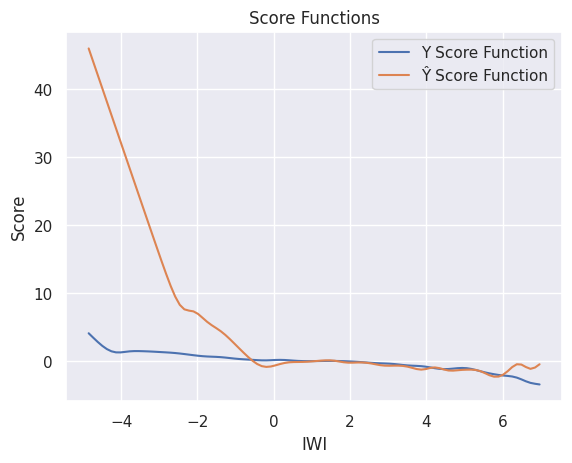

In [11]:
# Define evaluation points (avoid extreme values)
lower = np.percentile(targets, 2.5)
upper = np.percentile(targets, 97.5)
y_vals = np.linspace(min(targets), max(targets), 100)

# Finite difference step for derivative
delta = 1e-5

scores = []
pred_scores = []

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

for y in y_vals:
    
    # Derivative of log density for targets
    scores.append(score_function(y, target_kde))

    # Derivative of log density for predictions
    pred_scores.append(score_function(y, pred_kde))

# Plot score function
plt.plot(y_vals, scores, label="Y Score Function")
plt.plot(y_vals, pred_scores, label="Ŷ Score Function")
plt.title("Score Functions")
plt.xlabel("IWI")
plt.ylabel("Score")
plt.legend()
plt.show()

Use the variance of the residuals on the validation set as a substitute for the test set

In [12]:
with torch.no_grad():
    val_predictions = mse_model(X_val).cpu().numpy()
    val_targets = y_val.cpu().numpy()

    res_std = (val_predictions - val_targets).std()

print('Var(Y - Y-hat):', res_std)

Var(Y - Y-hat): 1.2725936


Estimate the score for each prediction in the test set

In [13]:
prediction_scores = np.array([score_function(y, pred_kde) for y in tqdm(predictions)])

100%|██████████| 10000/10000 [00:09<00:00, 1034.39it/s]


Use our method derived from Tweedie's formula to adjust the predicted ATE. As expected, the adjusted value is much closer to the "Sample ATE".

In [14]:
predicted_adjusted_sample_ate = predicted_sample_ate - res_std**2 * calculate_ate_iptw(prediction_scores, treatment_status, propensity_score)

print(f"Sample ATE: {sample_ate:.4f}")
print(f"Predicted Sample ATE: {predicted_sample_ate:.4f}")
print(f"Adjusted Predicted Sample ATE: {predicted_adjusted_sample_ate:.4f}")

Sample ATE: 1.9780
Predicted Sample ATE: 1.2474
Adjusted Predicted Sample ATE: 1.9263


Run bootstrap to get bounds for estimates

In [15]:
n_bootstraps = 1000
bootstrapped_ates = []
bootstrapped_pred_ates = []
bootstrapped_corrected_pred_ates = []

for _ in tqdm(range(n_bootstraps)):
    # Resample the data with replacement
    indices = np.random.choice(len(targets), len(targets), replace=True)
    boot_targets = targets[indices]
    boot_predictions = predictions[indices]
    boot_treatment_status = treatment_status[indices]
    boot_propensity_score = propensity_score[indices]
    boot_prediction_scores = prediction_scores[indices]

    # Calculate the ATE for the bootstrapped sample
    boot_ate = calculate_ate_iptw(boot_targets, boot_treatment_status, boot_propensity_score)
    boot_pred_ate = calculate_ate_iptw(boot_predictions, boot_treatment_status, boot_propensity_score)
    boot_corrected_pred_ate = boot_pred_ate - res_std**2 * calculate_ate_iptw(boot_prediction_scores, boot_treatment_status, boot_propensity_score)

    # Store the ATE
    bootstrapped_ates.append(boot_ate)
    bootstrapped_pred_ates.append(boot_pred_ate)
    bootstrapped_corrected_pred_ates.append(boot_corrected_pred_ate)

# Convert to numpy arrays
bootstrapped_ates = np.array(bootstrapped_ates)
bootstrapped_pred_ates = np.array(bootstrapped_pred_ates)
bootstrapped_corrected_pred_ates = np.array(bootstrapped_corrected_pred_ates)

  5%|▌         | 52/1000 [00:00<00:02, 426.72it/s]


KeyboardInterrupt: 

In [ ]:
# Calculate the mean and 95% confidence intervals
ate_mean = np.mean(bootstrapped_ates)
ate_ci = np.percentile(bootstrapped_ates, [2.5, 97.5])
pred_ate_mean = np.mean(bootstrapped_pred_ates)
pred_ate_ci = np.percentile(bootstrapped_pred_ates, [2.5, 97.5])
corrected_pred_ate_mean = np.mean(bootstrapped_corrected_pred_ates)
corrected_pred_ate_ci = np.percentile(bootstrapped_corrected_pred_ates, [2.5, 97.5])
print(f"Bootstrapped ATE: {ate_mean:.4f}, 95% CI: {ate_ci}")
print(f"Bootstrapped Predicted ATE: {pred_ate_mean:.4f}, 95% CI: {pred_ate_ci}")
print(f"Bootstrapped Corrected Predicted ATE: {corrected_pred_ate_mean:.4f}, 95% CI: {corrected_pred_ate_ci}")

Bootstrapped ATE: 1.9792, 95% CI: [1.90704695 2.05604795]
Bootstrapped Predicted ATE: 1.2487, 95% CI: [1.17664074 1.31987844]
Bootstrapped Corrected Predicted ATE: 1.9272, 95% CI: [1.81911287 2.03883512]


## Ratledge method

The paper by Ratledge et al. presents another way of controlling for bias with a custom loss function that aims to minimize MSE for each quintile. We train a separate $f_R$ model using this loss instead.

  5%|▍         | 2388/50000 [00:12<04:15, 186.19it/s]


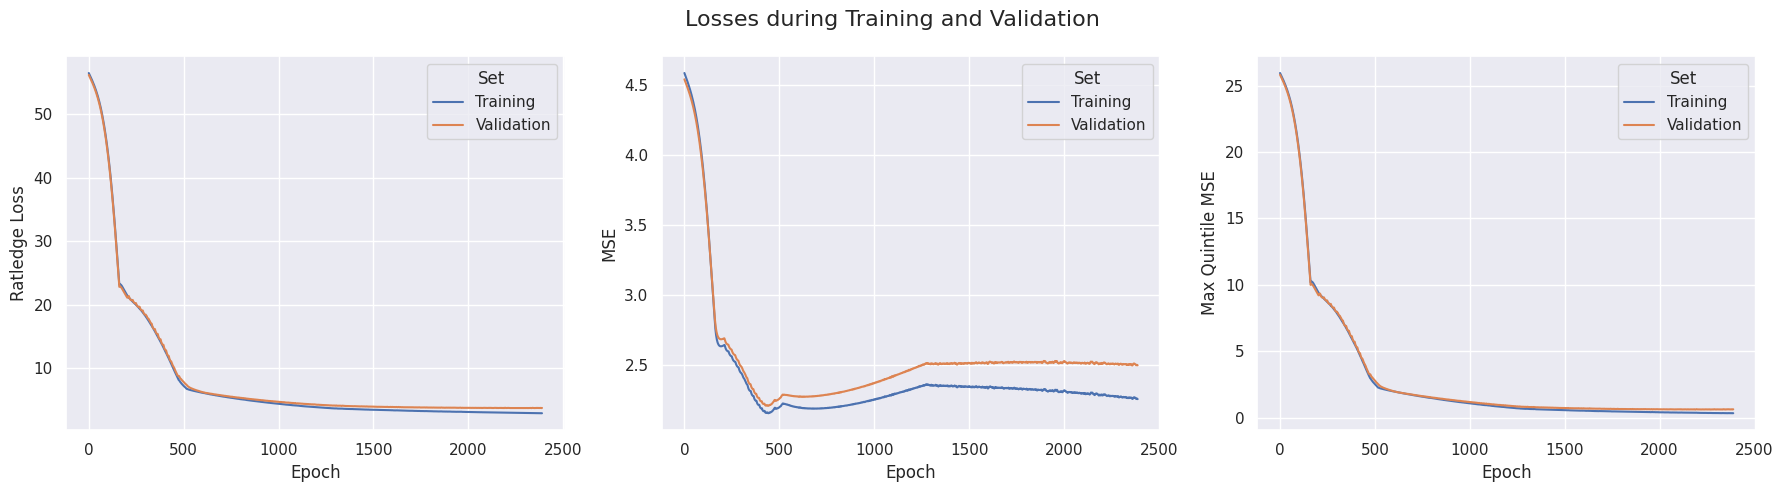

In [16]:
'''def max_mse_by_quintile(pred, target):
    # Get the quintile boundaries (0%, 20%, 40%, 60%, 80%, 100%)
    quantiles = torch.quantile(target, torch.tensor([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).cuda())

    max_quintile_mse = torch.tensor(float('-inf')).cuda()

    for i in range(5):
        lower = quantiles[i]
        upper = quantiles[i+1]
        
        # Create mask for current quintile
        if i < 4:
            mask = (target >= lower) & (target < upper)
        else:
            mask = (target >= lower) & (target <= upper)

        # Calculate MSE for the current quintile
        if mask.sum() > 0:
            mse = nn.MSELoss()(pred[mask], target[mask])
        else:
            mse = torch.tensor(float('-inf')).cuda()  # So it won't affect max if empty

        if mse > max_quintile_mse:
            max_quintile_mse = mse

    # Get the max MSE
    return max_quintile_mse'''

class RatledgeLoss(nn.Module):
    def __init__(self, quants, lambda_b=5.0):
        """
        Args:
          quants: 1-D Tensor of shape (6,) giving the 0%,20%,…,100% IWI cut-points
                  computed once on the full training set.
          lambda_b: weight on the max-bias penalty
        """
        super().__init__()
        self.register_buffer('quants', quants)  
        self.lambda_b = lambda_b

    def forward(self, y_pred, y_true):
        # 1) Standard MSE on the whole batch
        mse = nn.functional.mse_loss(y_pred, y_true)

        # 2) Compute squared bias per quintile, take the max
        max_bias2 = torch.tensor(0., device=y_true.device)
        for j in range(5):
            lo, hi = self.quants[j], self.quants[j+1]
            if j < 4:
                mask = (y_true >= lo) & (y_true < hi)
            else:
                mask = (y_true >= lo) & (y_true <= hi)

            if mask.any():
                bias_j = (y_pred[mask] - y_true[mask]).mean()
                bias2_j = bias_j.pow(2)
                max_bias2 = torch.max(max_bias2, bias2_j)

        return mse + self.lambda_b * max_bias2

class MaxMseByQuintile(nn.Module):
    def __init__(self, quants, lambda_b=5.0):
        """
        Args:
          quants: 1-D Tensor of shape (6,) giving the 0%,20%,…,100% IWI cut-points
                  computed once on the full training set.
          lambda_b: weight on the max-bias penalty
        """
        super().__init__()
        self.register_buffer('quants', quants)  
        self.lambda_b = lambda_b

    def forward(self, y_pred, y_true):

        # Compute squared bias per quintile, take the max
        max_bias2 = torch.tensor(0., device=y_true.device)
        for j in range(5):
            lo, hi = self.quants[j], self.quants[j+1]
            if j < 4:
                mask = (y_true >= lo) & (y_true < hi)
            else:
                mask = (y_true >= lo) & (y_true <= hi)

            if mask.any():
                bias_j = (y_pred[mask] - y_true[mask]).mean()
                bias2_j = bias_j.pow(2)
                max_bias2 = torch.max(max_bias2, bias2_j)

        return self.lambda_b * max_bias2

lambda_b = 2
lambda_r = 1e-2
lr = 1e-4

quants_tensor = torch.quantile(y_train, torch.tensor([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], device=device))
max_mse_by_quintile = MaxMseByQuintile(quants_tensor, lambda_b=lambda_b)

# Example of a loss function that only tracks one metric (MSE)
def ratledge_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    max_quintile_mse = max_mse_by_quintile(pred, target)
    loss = mse + lambda_b * max_quintile_mse
    return loss, {'Ratledge Loss': loss.item(), 'MSE': mse.item(), 'Max Quintile MSE': max_quintile_mse.item()}

ratledge_model = train_model(X_train, X_val, y_train, y_val, lr=lr, l2=lambda_r, loss_fn=ratledge_loss, verbose=1)

Plot results on test set

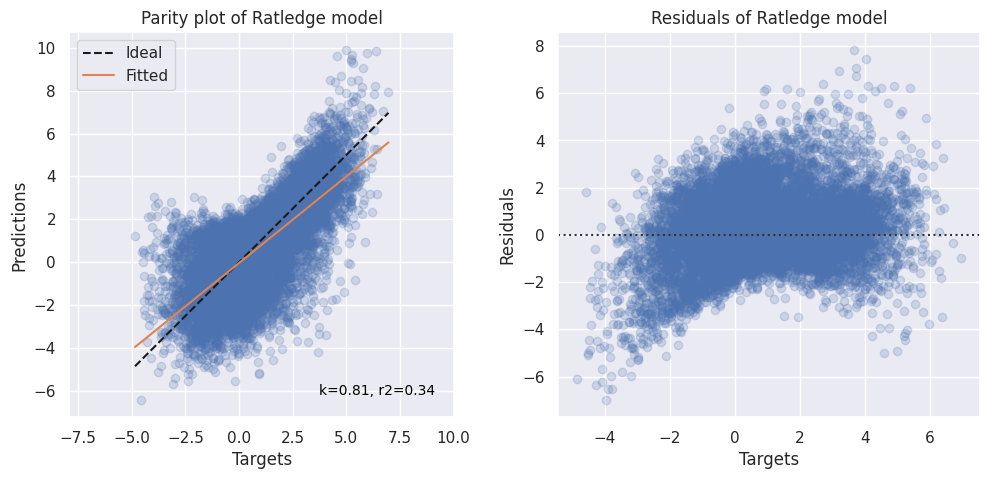

In [17]:
with torch.no_grad():
    ratledge_pred = ratledge_model(X_test)

y_test = torch.tensor(test_population['Y'].values, dtype=torch.float).to(device)
plot_results(y_test, ratledge_pred, 'Ratledge model')

The idea is that the new loss term should break the relationship between "Targets" and "Residuals", but I haven't been able to do so.

## Compare bias correction methods

In order to compare different methods of bias correction when estimating $\tau$, I redo the experiment multiple times using different populations, varying the true value $\tau$. I run 50 rounds with $\tau$ between -2 and 2. For each round, I also resample a new $g$ function for generating the "image" embedding $X$ from $Y$. For each round, I calculate five estimates of $\tau$:

- **Sample ATE**: Simply the ATE you get using the target labels $Y$ for the given sample. This can be seen as the "gold standard" estimate.
- **Predicted ATE**: The ATE you get using the predicted values $\hat{Y}$ from the MSE model. This should be biased towards zero such that the magnitude of $\tau$ is underestimated.
- **Tweedie Adjusted Predicted ATE**: The ATE you get using the predicted values $\hat{Y}$ from the MSE model plus the adjustment term I've derived from Tweedie´s formula. This should give an unbiased estimate of $\tau$.
- **KM Adjusted Predicted ATE**: The ATE you get using the $km$-adjusted values from the MSE model. TODO: Add better explanation

In [18]:
n_trials = 51
taus = np.linspace(-2, 2, n_trials)

ates = []
pred_ates = []
corrected_pred_ates = []
km_pred_ates = []
ratledge_pred_ates = []

mse_r2s = []
ratledge_r2s = []
mse_maes = []
ratledge_maes = []

pbar = tqdm(taus)

for i, tau in enumerate(pbar):

    # Train model
    pbar.set_description('Generating population...')
    emb_model = EmbeddingGenerator(input_dim=1)
    population = generate_population(emb_model, n_samples=10000, tau=tau, alpha=1.0, sigma_Y=1.0, sigma_X=0.3, seed=RANDOM_STATE+i)

    X = np.stack(population['X'].values)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    Y = population['Y'].values

    X = torch.tensor(X, dtype=torch.float).to(device)
    Y = torch.tensor(Y, dtype=torch.float).to(device)

    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE+i)

    pbar.set_description('Training MSE model...')
    mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)
    pbar.set_description('Training Ratledge model...')
    ratledge_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=ratledge_loss, verbose=0)

    # Evaluate
    pbar.set_description('Predicting...')
    test_population = generate_population(emb_model, n_samples=10000, tau=tau, alpha=1.0, sigma_Y=1.0, sigma_X=0.3, seed=RANDOM_STATE+1+i)

    X_test = np.stack(test_population['X'].values)
    X_test = scaler.transform(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float).to(device)

    with torch.no_grad():
        y_mse_pred = mse_model(X_test)
        y_ratledge_pred = ratledge_model(X_test)

        val_predictions = mse_model(X_val).cpu().numpy()
        val_targets = y_val.cpu().numpy()

        res_std = (val_predictions - val_targets).std()

    km_regressor = LinearRegression()
    km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

    k = km_regressor.coef_[0]
    m = km_regressor.intercept_

    mse_predictions = y_mse_pred.cpu().numpy()
    km_predictions = (mse_predictions - m) / k
    ratledge_predictions = y_ratledge_pred.cpu().numpy()
    targets = test_population['Y'].values
    treatment_status = test_population['T']
    propensity_score = test_population['p_T_given_C'].values

    pbar.set_description('Calculating scores...')
    pred_kde = gaussian_kde(mse_predictions)
    mse_prediction_scores = np.array([score_function(y, pred_kde) for y in mse_predictions])

    pbar.set_description('Estimating ATEs...')
    # Calculate the ATE for the bootstrapped sample
    ate = calculate_ate_iptw(targets, treatment_status, propensity_score)
    pred_ate = calculate_ate_iptw(mse_predictions, treatment_status, propensity_score)
    corrected_pred_ate = pred_ate - res_std**2 * calculate_ate_iptw(mse_prediction_scores, treatment_status, propensity_score)
    km_pred_ate = calculate_ate_iptw(km_predictions, treatment_status, propensity_score)
    ratledge_pred_ate = calculate_ate_iptw(ratledge_predictions, treatment_status, propensity_score)

    # Store the ATE
    ates.append(ate)
    pred_ates.append(pred_ate)
    corrected_pred_ates.append(corrected_pred_ate)
    km_pred_ates.append(km_pred_ate)
    ratledge_pred_ates.append(ratledge_pred_ate)

    # Calculate R2 and MAE
    mse_r2 = r2_score(targets, mse_predictions)
    ratledge_r2 = r2_score(targets, ratledge_predictions)
    mse_mae = mean_absolute_error(targets, mse_predictions)
    ratledge_mae = mean_absolute_error(targets, ratledge_predictions)
    
    mse_r2s.append(mse_r2)
    ratledge_r2s.append(ratledge_r2)
    mse_maes.append(mse_mae)
    ratledge_maes.append(ratledge_mae)


Training Ratledge model...:   4%|▍         | 2/51 [00:34<14:04, 17.23s/it]


KeyboardInterrupt: 

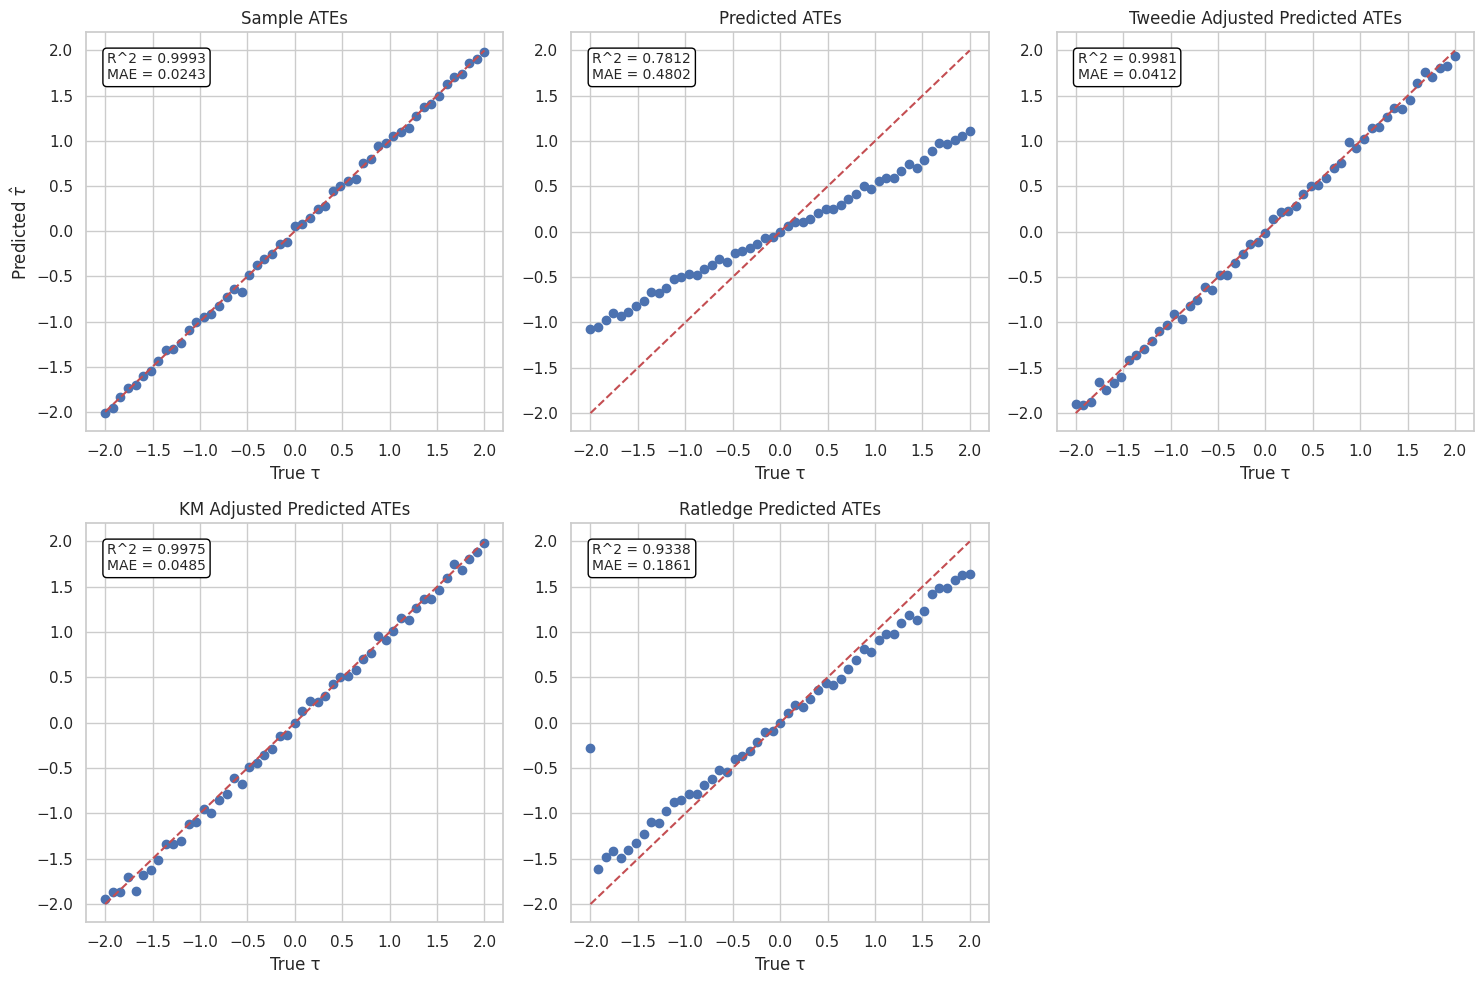

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.scatter(taus, ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, ates)
mae = mean_absolute_error(taus, ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.ylabel('Predicted $\hat{τ}$')
plt.title('Sample ATEs')

plt.subplot(2, 3, 2)
plt.scatter(taus, pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, pred_ates)
mae = mean_absolute_error(taus, pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Predicted ATEs')

plt.subplot(2, 3, 3)
plt.scatter(taus, corrected_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, corrected_pred_ates)
mae = mean_absolute_error(taus, corrected_pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Tweedie Adjusted Predicted ATEs')

plt.subplot(2, 3, 4)
plt.scatter(taus, km_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, km_pred_ates)
mae = mean_absolute_error(taus, km_pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('KM Adjusted Predicted ATEs')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.scatter(taus, ratledge_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, ratledge_pred_ates)
mae = mean_absolute_error(taus, ratledge_pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Ratledge Predicted ATEs')
plt.tight_layout()
plt.show()

In [25]:
sns.set_style("whitegrid")

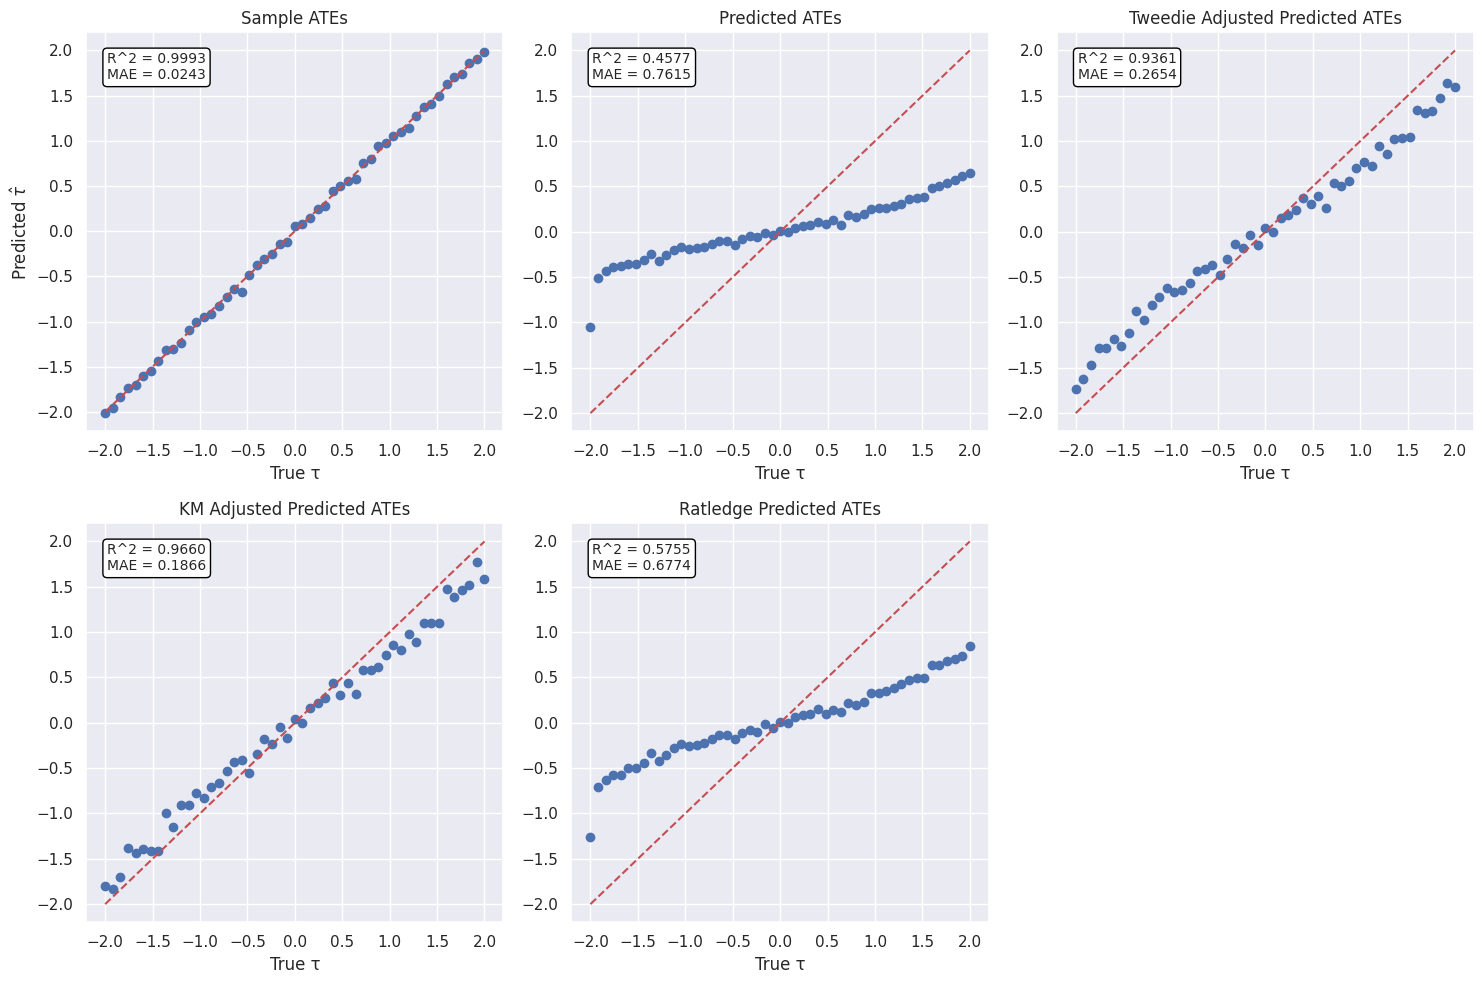

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.scatter(taus, ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, ates)
mae = mean_absolute_error(taus, ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.ylabel('Predicted $\hat{τ}$')
plt.title('Sample ATEs')

plt.subplot(2, 3, 2)
plt.scatter(taus, pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, pred_ates)
mae = mean_absolute_error(taus, pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Predicted ATEs')

plt.subplot(2, 3, 3)
plt.scatter(taus, corrected_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, corrected_pred_ates)
mae = mean_absolute_error(taus, corrected_pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Tweedie Adjusted Predicted ATEs')

plt.subplot(2, 3, 4)
plt.scatter(taus, km_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, km_pred_ates)
mae = mean_absolute_error(taus, km_pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('KM Adjusted Predicted ATEs')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.scatter(taus, ratledge_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
r2 = r2_score(taus, ratledge_pred_ates)
mae = mean_absolute_error(taus, ratledge_pred_ates)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Ratledge Predicted ATEs')
plt.tight_layout()
plt.show()

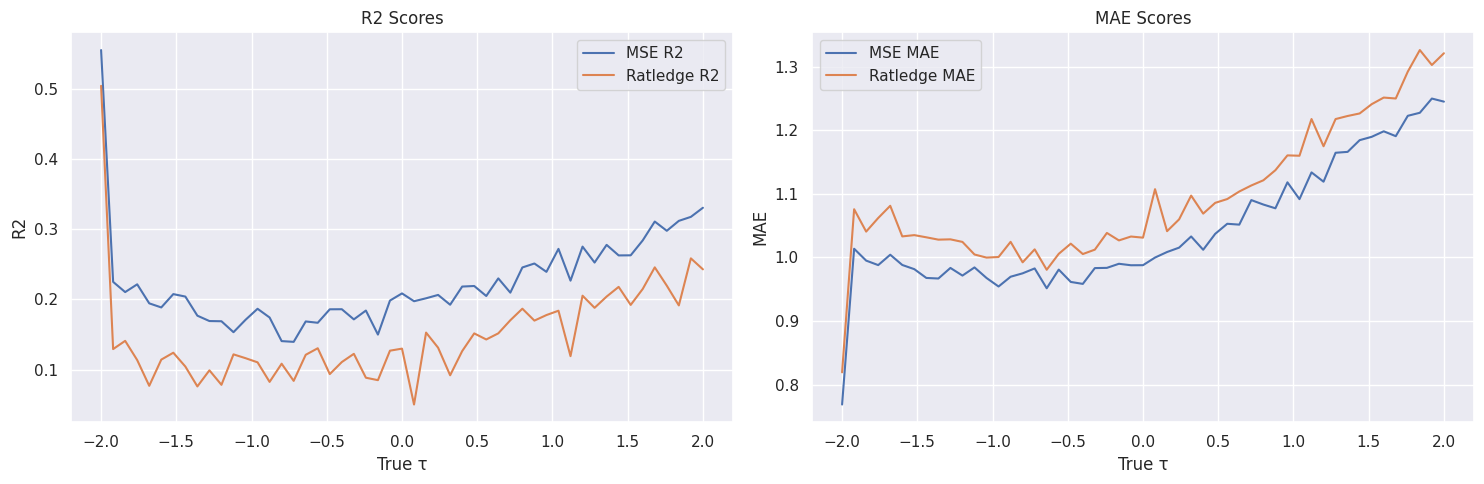

In [24]:
# Plot the R2 and MAE for both models
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(taus, mse_r2s, label='MSE R2')
plt.plot(taus, ratledge_r2s, label='Ratledge R2')
plt.xlabel('True τ')
plt.ylabel('R2')
plt.title('R2 Scores')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(taus, mse_maes, label='MSE MAE')
plt.plot(taus, ratledge_maes, label='Ratledge MAE')
plt.xlabel('True τ')
plt.ylabel('MAE')
plt.title('MAE Scores')
plt.legend()
plt.tight_layout()
plt.show()

## Prediction Powered Inference

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

def prediction_powered_weighted_mean(Y_hat_unlabeled, w_unlabeled,
                                     Y_hat_labeled,   w_labeled,
                                     Y_labeled):
    """
    Computes an unbiased weighted mean estimate using prediction-powered inference.
    """
    mu_unl  = np.sum(w_unlabeled * Y_hat_unlabeled) / np.sum(w_unlabeled)
    corr    = np.sum(w_labeled   * (Y_labeled - Y_hat_labeled))   / np.sum(w_labeled)
    return mu_unl + corr

def calculate_ate_ppi_ipw(predictions, labels, treatment, propensity,
                          n_labeled=1000, random_state=None):
    """
    Estimate ATE by:
      1) Splitting off n_labeled examples as the 'labeled set'
      2) Computing IPTW weights on both unlabeled and labeled
      3) For each arm (T=1 vs T=0), running PPI to get a corrected mean
      4) Taking the difference of treated minus control.
    """
    # 1) split off a labeled set
    (Y_hat_unlabeled, Y_hat_labeled,
     Y_unlabeled,     Y_labeled,
     T_unlabeled,     T_labeled,
     e_unlabeled,     e_labeled) = train_test_split(
        predictions, labels, treatment, propensity,
        test_size=n_labeled, random_state=random_state
    )

    # 2) clip props to avoid div/0
    eps = 1e-6
    e_unlabeled = np.clip(e_unlabeled, eps, 1 - eps)
    e_labeled   = np.clip(e_labeled,   eps, 1 - eps)

    # 3) build IPTW weights
    w_unl_treated =  T_unlabeled   / e_unlabeled
    w_unl_control = (1 - T_unlabeled) / (1 - e_unlabeled)
    w_lab_treated =  T_labeled     / e_labeled
    w_lab_control = (1 - T_labeled)   / (1 - e_labeled)

    # 4) slice out predictions & weights by arm
    #   treated
    Y_hat_unl_t = Y_hat_unlabeled[T_unlabeled == 1]
    w_unl_t    = w_unl_treated  [T_unlabeled == 1]
    Y_hat_lab_t = Y_hat_labeled  [T_labeled   == 1]
    w_lab_t    = w_lab_treated  [T_labeled   == 1]
    Y_lab_t    = Y_labeled      [T_labeled   == 1]

    #   control
    phat_unl_c = Y_hat_unlabeled[T_unlabeled == 0]
    w_unl_c    = w_unl_control  [T_unlabeled == 0]
    phat_lab_c = Y_hat_labeled  [T_labeled   == 0]
    w_lab_c    = w_lab_control  [T_labeled   == 0]
    Y_lab_c    = Y_labeled      [T_labeled   == 0]

    # 5) compute PPI means
    mu_treated = prediction_powered_weighted_mean(
        Y_hat_unl_t, w_unl_t,
        Y_hat_lab_t, w_lab_t,
        Y_lab_t
    )
    mu_control = prediction_powered_weighted_mean(
        phat_unl_c, w_unl_c,
        phat_lab_c, w_lab_c,
        Y_lab_c
    )

    # 6) ATE = difference
    ate_ppi_ipw = mu_treated - mu_control
    return ate_ppi_ipw

PPI_ATE = calculate_ate_ppi_ipw(
    predictions=predictions,
    labels=targets,
    treatment=treatment_status,
    propensity=propensity_score,
    n_labeled=100,
    random_state=RANDOM_STATE
)
print(f"ATE (IPTW + PPI): {PPI_ATE:.4f}")


ATE (IPTW + PPI): -0.5545


In [20]:
n_trials = 50
n_labeled = 100  # For PPI
taus = np.linspace(-2, 2, n_trials)

ates = []
pred_ates = []
corrected_pred_ates = []
km_pred_ates = []
ratledge_pred_ates = []
ppi_pred_ates = []

mse_r2s = []
ratledge_r2s = []
mse_maes = []
ratledge_maes = []

pbar = tqdm(taus)

for i, tau in enumerate(pbar):

    # Train model
    pbar.set_description('Generating population...')
    emb_model = EmbeddingGenerator()
    population = generate_population(emb_model, n_samples=10000, tau=tau, alpha=1.0, sigma_Y=1.0, sigma_X=0.3, seed=RANDOM_STATE+i)

    X = np.stack(population['X'].values)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    Y = population['Y'].values

    X = torch.tensor(X, dtype=torch.float).to(device)
    Y = torch.tensor(Y, dtype=torch.float).to(device)

    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE+i)

    pbar.set_description('Training MSE model...')
    mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)
    pbar.set_description('Training Ratledge model...')
    ratledge_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=ratledge_loss, verbose=0)

    # Evaluate
    pbar.set_description('Predicting...')
    test_population = generate_population(emb_model, n_samples=10000, tau=tau, alpha=1.0, sigma_Y=1.0, sigma_X=0.3, seed=RANDOM_STATE+1+i)

    X_test = np.stack(test_population['X'].values)
    X_test = scaler.transform(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float).to(device)

    with torch.no_grad():
        y_mse_pred = mse_model(X_test)
        y_ratledge_pred = ratledge_model(X_test)

        val_predictions = mse_model(X_val).cpu().numpy()
        val_targets = y_val.cpu().numpy()

        res_std = (val_predictions - val_targets).std()

    km_regressor = LinearRegression()
    km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

    k = km_regressor.coef_[0]
    m = km_regressor.intercept_

    mse_predictions = y_mse_pred.cpu().numpy()
    km_predictions = (mse_predictions - m) / k
    ratledge_predictions = y_ratledge_pred.cpu().numpy()
    targets = test_population['Y'].values
    treatment_status = test_population['T']
    propensity_score = test_population['p_T_given_C'].values

    pbar.set_description('Calculating scores...')
    pred_kde = gaussian_kde(mse_predictions)
    mse_prediction_scores = np.array([score_function(y, pred_kde) for y in mse_predictions])

    pbar.set_description('Estimating ATEs...')
    # Calculate the ATE for the bootstrapped sample
    ate = calculate_ate_iptw(targets, treatment_status, propensity_score)
    pred_ate = calculate_ate_iptw(mse_predictions, treatment_status, propensity_score)
    corrected_pred_ate = pred_ate - res_std**2 * calculate_ate_iptw(mse_prediction_scores, treatment_status, propensity_score)
    km_pred_ate = calculate_ate_iptw(km_predictions, treatment_status, propensity_score)
    ratledge_pred_ate = calculate_ate_iptw(ratledge_predictions, treatment_status, propensity_score)

    # PPI
    ppi_pred_ate = calculate_ate_ppi_ipw(
        predictions=mse_predictions,
        labels=targets,
        treatment=treatment_status,
        propensity=propensity_score,
        n_labeled=n_labeled,
        random_state=RANDOM_STATE
    )

    # Store the ATE
    ates.append(ate)
    pred_ates.append(pred_ate)
    corrected_pred_ates.append(corrected_pred_ate)
    km_pred_ates.append(km_pred_ate)
    ratledge_pred_ates.append(ratledge_pred_ate)
    ppi_pred_ates.append(ppi_pred_ate)

    # Calculate R2 and MAE
    mse_r2 = r2_score(targets, mse_predictions)
    ratledge_r2 = r2_score(targets, ratledge_predictions)
    mse_mae = mean_absolute_error(targets, mse_predictions)
    ratledge_mae = mean_absolute_error(targets, ratledge_predictions)
    
    mse_r2s.append(mse_r2)
    ratledge_r2s.append(ratledge_r2)
    mse_maes.append(mse_mae)
    ratledge_maes.append(ratledge_mae)


Estimating ATEs...: 100%|██████████| 50/50 [18:29<00:00, 22.18s/it]        


In [21]:
print('taus =', list(taus))
print('ates =', ates)
print('pred_ates =', pred_ates)
print('corrected_pred_ates =', corrected_pred_ates)
print('km_pred_ates =', km_pred_ates)
print('ratledge_pred_ates =', ratledge_pred_ates)
print('ppi_pred_ates =', ppi_pred_ates)

taus = [-2.0, -1.9183673469387754, -1.836734693877551, -1.7551020408163265, -1.6734693877551021, -1.5918367346938775, -1.510204081632653, -1.4285714285714286, -1.3469387755102042, -1.2653061224489797, -1.183673469387755, -1.1020408163265307, -1.0204081632653061, -0.9387755102040818, -0.8571428571428572, -0.7755102040816328, -0.6938775510204083, -0.6122448979591837, -0.5306122448979593, -0.44897959183673475, -0.3673469387755104, -0.2857142857142858, -0.20408163265306145, -0.12244897959183687, -0.04081632653061229, 0.04081632653061229, 0.12244897959183643, 0.204081632653061, 0.2857142857142856, 0.36734693877551017, 0.4489795918367343, 0.5306122448979589, 0.6122448979591835, 0.693877551020408, 0.7755102040816326, 0.8571428571428568, 0.9387755102040813, 1.020408163265306, 1.1020408163265305, 1.1836734693877546, 1.2653061224489792, 1.3469387755102038, 1.4285714285714284, 1.510204081632653, 1.591836734693877, 1.6734693877551017, 1.7551020408163263, 1.8367346938775508, 1.9183673469387754, 2.0

In [2]:
taus = [-2.0, -1.9183673469387754, -1.836734693877551, -1.7551020408163265, -1.6734693877551021, -1.5918367346938775, -1.510204081632653, -1.4285714285714286, -1.3469387755102042, -1.2653061224489797, -1.183673469387755, -1.1020408163265307, -1.0204081632653061, -0.9387755102040818, -0.8571428571428572, -0.7755102040816328, -0.6938775510204083, -0.6122448979591837, -0.5306122448979593, -0.44897959183673475, -0.3673469387755104, -0.2857142857142858, -0.20408163265306145, -0.12244897959183687, -0.04081632653061229, 0.04081632653061229, 0.12244897959183643, 0.204081632653061, 0.2857142857142856, 0.36734693877551017, 0.4489795918367343, 0.5306122448979589, 0.6122448979591835, 0.693877551020408, 0.7755102040816326, 0.8571428571428568, 0.9387755102040813, 1.020408163265306, 1.1020408163265305, 1.1836734693877546, 1.2653061224489792, 1.3469387755102038, 1.4285714285714284, 1.510204081632653, 1.591836734693877, 1.6734693877551017, 1.7551020408163263, 1.8367346938775508, 1.9183673469387754, 2.0]
ates = [-2.014040878924981, -1.951730805442993, -1.8329637454719905, -1.7339555301315712, -1.6974409298189923, -1.5989077757539667, -1.5354981731737896, -1.4270743125073326, -1.300186676459761, -1.2881636114399428, -1.217848178521553, -1.0811913505836173, -0.9889552976496677, -0.9292356225366079, -0.8937521767671991, -0.8032073912956872, -0.69871774224295, -0.6137391594257923, -0.6406260067779577, -0.45020475475497734, -0.3430574983146092, -0.2763860895349159, -0.21430788897259018, -0.10333100781933333, -0.08037323604883075, 0.09439234066297174, 0.12142540410864883, 0.1910788931558533, 0.29335600780417614, 0.32687020922152793, 0.4921943446164737, 0.5466508231297211, 0.6052871256038403, 0.629018569740617, 0.8154278276868977, 0.8549779554723885, 0.9970965509642857, 1.0326965735851246, 1.117247379189245, 1.1610191461487287, 1.2064290716089165, 1.3443374405754298, 1.4458916814880671, 1.4805515299884777, 1.5652560568858898, 1.7006254806814323, 1.7857051056991156, 1.8183178696747149, 1.933967284281813, 1.9820131258556568]
pred_ates = [-1.0748317849456848, -1.0458416776127604, -0.9681848634918689, -0.8962938123597843, -0.9318222569847516, -0.8781265246006378, -0.8189689635423032, -0.7568779616984999, -0.6576878588221191, -0.6671640311978192, -0.6149429315087762, -0.5134787432932618, -0.49245542873446846, -0.4546505197081575, -0.46294752727527694, -0.4013745351551679, -0.35184500928000617, -0.28664140249043973, -0.31585765952004907, -0.22176714467426017, -0.19856136455538137, -0.15828409997378962, -0.11559105544914677, -0.048395855625729685, -0.04397586373225937, 0.018066292525321125, 0.08568854085107762, 0.13415929109663285, 0.1319970388352816, 0.16676422420459955, 0.23143416343578055, 0.282403938444951, 0.2793662243997844, 0.322965378843983, 0.38958311222431957, 0.45180702210511, 0.5443256359935125, 0.5053756103130207, 0.5965585655313953, 0.630944684842122, 0.6348459764330621, 0.7123133131972968, 0.7839865637811481, 0.7560337484634645, 0.8346308225658274, 0.9347617443487126, 1.0364914110428374, 1.0266698382553752, 1.0676159734705137, 1.1191117012608602]
corrected_pred_ates = [-1.9015895154567246, -1.9041438104265778, -1.8797924632177334, -1.6464371894144494, -1.740321414270873, -1.6598693648288703, -1.5856029178908078, -1.4078517057305997, -1.3479842616105135, -1.275245329866383, -1.1883157208019566, -1.078075798966223, -1.009222531459586, -0.8920172207342723, -0.9405670723205346, -0.7940105863988884, -0.7254033407307338, -0.5875933654160143, -0.6153424855374806, -0.44356255914485454, -0.4417397791957197, -0.3080552506882752, -0.20642804790700214, -0.10005038154089912, -0.06661388341959758, 0.030825420415911606, 0.17731322769001537, 0.2631055367814456, 0.2769927719583365, 0.3369654694019212, 0.46477226213625, 0.5551843702381007, 0.5619564608584983, 0.6515968500290816, 0.7550148233871891, 0.8196153626110958, 1.0544133236794004, 0.9869057491574392, 1.0782459978901513, 1.2042071873201898, 1.2165047520203176, 1.3304370948776043, 1.42772159562092, 1.4312394007197344, 1.5167486023643661, 1.7108283189708469, 1.8436109154828988, 1.7800370941189763, 1.8941407545174709, 1.9111443665192627]
km_pred_ates = [-1.938937839836128, -1.869742708645325, -1.8677611148764477, -1.6985833382890836, -1.8549566838691276, -1.6705426216449244, -1.6173308702067501, -1.5039987154849728, -1.327594484563667, -1.3197754069117913, -1.2851584145969626, -1.095837742352551, -1.0706613702665244, -0.9342374484696826, -0.9670966226145187, -0.8295816101888326, -0.7628736659157351, -0.5768165279579476, -0.6417204163781213, -0.458855568730238, -0.4142494011704009, -0.32630313546627204, -0.24981629977117972, -0.1058725336204386, -0.09256576305881342, 0.03776738346631144, 0.1770170690372448, 0.2850721569090882, 0.27514978325315476, 0.33999063505731575, 0.4798458736400668, 0.5504630233150394, 0.5682117646447967, 0.6394014853873691, 0.7577984201804531, 0.8237378678240166, 1.0215110884311414, 0.9795239658597635, 1.0702341943937954, 1.2155143814178264, 1.202938614713937, 1.3275620356212094, 1.4329385613122825, 1.4445541301486722, 1.5460463661733872, 1.670349403896325, 1.8369312890684735, 1.7582674425134162, 1.8832786388743619, 1.969962279557186]
ratledge_pred_ates = [-0.2735913071620168, -1.608411027751584, -1.5046749084122173, -1.4138959811994543, -1.4894155060455994, -1.3918207203507464, -1.3094759232088755, -1.2184563314884487, -1.0834961027729786, -1.0894195544935341, -0.9603909056876769, -0.8616568595127017, -0.8284807615600853, -0.7617235118652123, -0.7680077659927936, -0.6685033023002996, -0.5971354565141941, -0.4955442074386925, -0.5228865899723756, -0.3699832625531095, -0.33541696298731855, -0.28766118603945817, -0.18989703767009172, -0.07607808646162025, -0.056616179216072544, 0.031727151547184515, 0.143990998376106, 0.22964827841258312, 0.21300016591222748, 0.29985999162204685, 0.4013209389355321, 0.48061879658568696, 0.464233868307384, 0.5313717778426295, 0.6507066563871998, 0.7381921713934579, 0.8639357163802095, 0.8335847304119212, 0.969192282529514, 1.0428977591763808, 1.034994289835561, 1.1632309497420217, 1.2520101228624883, 1.2008839629189607, 1.2927162315187282, 1.4933148106818925, 1.5507451915303803, 1.5539106764703452, 1.6163926933664488, 1.7085762443345063]
ppi_pred_ates = [-1.4168205303179857, -1.1606875390753189, -1.6432356184596901, -1.8260011656353439, -1.454369377869452, -1.9590532355047732, -1.5547612174259653, -1.1286680294534392, -1.2292458619320543, -1.4964302015471902, -1.1290816448644392, -0.885036527190587, -1.099899790304634, -0.9874359641158765, -0.9057596056339784, -0.5243283586985883, -0.7286563061364212, -0.14139773193902067, -0.27497892031305676, -0.5729059798495363, -0.3417730610033295, 0.24713347191637627, 0.11474342607224684, -0.11137827135464022, 0.10252422415077361, 0.14566674097590704, 0.128523773013166, 0.1271906443992316, 0.22456171739490138, 0.7132108673305209, 0.6418071978465711, 0.6149849093682854, 0.8178187842836183, 0.7213606673541286, 0.804572244153192, 1.1041034480393672, 0.9056576063523989, 1.4129956362976464, 1.3195250419879823, 1.325862305145142, 1.2391555626976698, 1.4644292615768344, 1.3118259259355738, 1.2923152587052724, 1.8560205735791653, 1.5369452036521714, 1.5925121065585557, 1.9866967443547787, 1.9829736026889053, 2.6471730638103352]

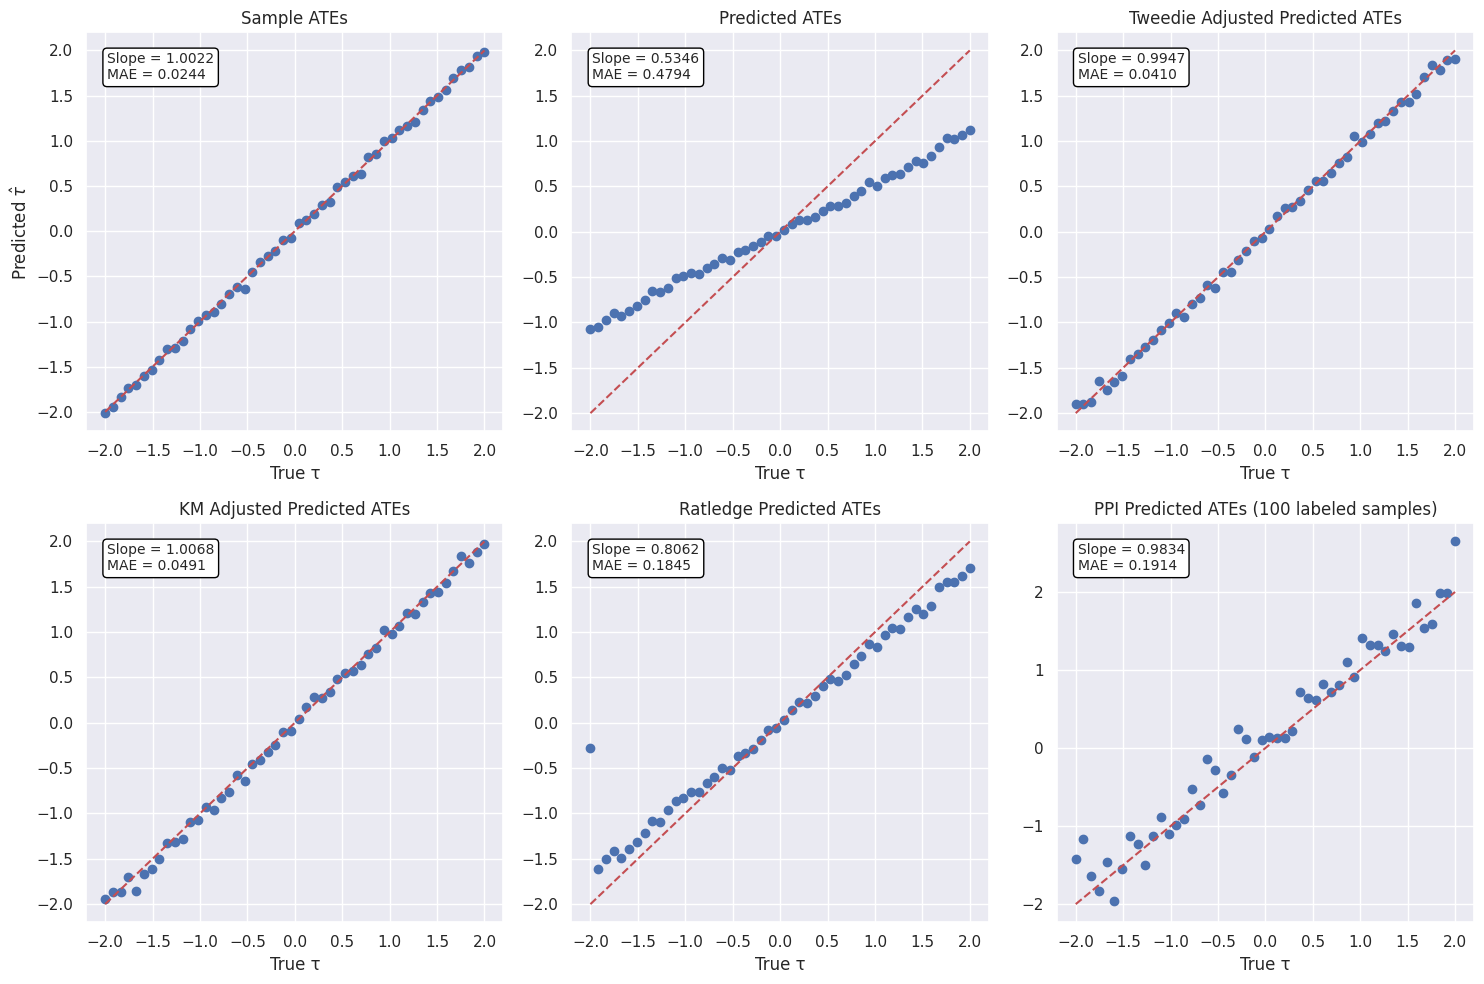

In [3]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.scatter(taus, ates)
# Add label with r^2 and MAE of ATE prediction to plot
mae = mean_absolute_error(taus, ates)
slope, _ = np.polyfit(taus, ates, 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.ylabel('Predicted $\hat{τ}$')
plt.title('Sample ATEs')

plt.subplot(2, 3, 2)
plt.scatter(taus, pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
mae = mean_absolute_error(taus, pred_ates)
slope, _ = np.polyfit(taus, pred_ates, 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Predicted ATEs')

plt.subplot(2, 3, 3)
plt.scatter(taus, corrected_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
mae = mean_absolute_error(taus, corrected_pred_ates)
slope, _ = np.polyfit(taus, corrected_pred_ates, 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Tweedie Adjusted Predicted ATEs')

plt.subplot(2, 3, 4)
plt.scatter(taus, km_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
mae = mean_absolute_error(taus, km_pred_ates)
slope, _ = np.polyfit(taus, km_pred_ates, 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('KM Adjusted Predicted ATEs')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.scatter(taus, ratledge_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
mae = mean_absolute_error(taus, ratledge_pred_ates)
slope, _ = np.polyfit(taus, ratledge_pred_ates, 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('Ratledge Predicted ATEs')

plt.subplot(2, 3, 6)
plt.scatter(taus, ppi_pred_ates)
# Add label with r^2 and MAE of ATE prediction to plot
mae = mean_absolute_error(taus, ppi_pred_ates)
slope, _ = np.polyfit(taus, ppi_pred_ates, 1)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel('True τ')
plt.title('PPI Predicted ATEs (100 labeled samples)')
plt.tight_layout()
plt.show()

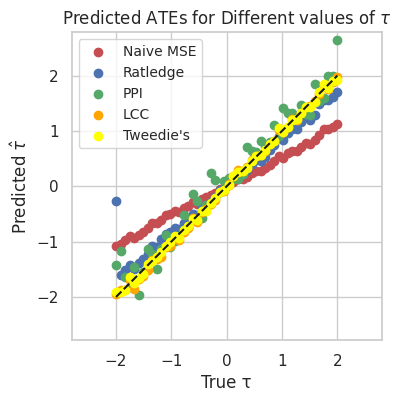

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(4, 4))
# plt.plot(taus, pred_ates, 'o-r', label='Naive MSE')
# plt.plot(taus, ratledge_pred_ates, 'o-b', label='Ratledge')
# plt.plot(taus, ppi_pred_ates, 'o-g', label='PPI')
plt.scatter(taus, pred_ates, c='r', label='Naive MSE')
plt.scatter(taus, ratledge_pred_ates, c='b', label='Ratledge')
plt.scatter(taus, ppi_pred_ates, c='g', label='PPI')
# plt.plot(taus, ates, color='gray', linestyle='-', marker='o', alpha=0.25)
plt.scatter(taus, km_pred_ates, c='orange', label='LCC')
plt.scatter(taus, corrected_pred_ates, c='yellow', label='Tweedie\'s')
#plt.plot(taus, corrected_pred_ates, color='yellow', linestyle='-', marker='o', label='Tweedie\'s correction')
#plt.plot(taus, km_pred_ates, color='orange', linestyle='-', marker='o', label='LCC correction')

plt.plot([-2, 2], [-2, 2], 'k--')
plt.xlabel('True τ')
plt.ylabel('Predicted $\hat{τ}$')
plt.title(r'Predicted ATEs for Different Values of $\tau$')
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.axis('equal')
x = 2.8
plt.xlim(-x, x)
plt.ylim(-x, x)

plt.savefig('figures/simulated_ate_estimates.png', bbox_inches='tight', dpi=300)

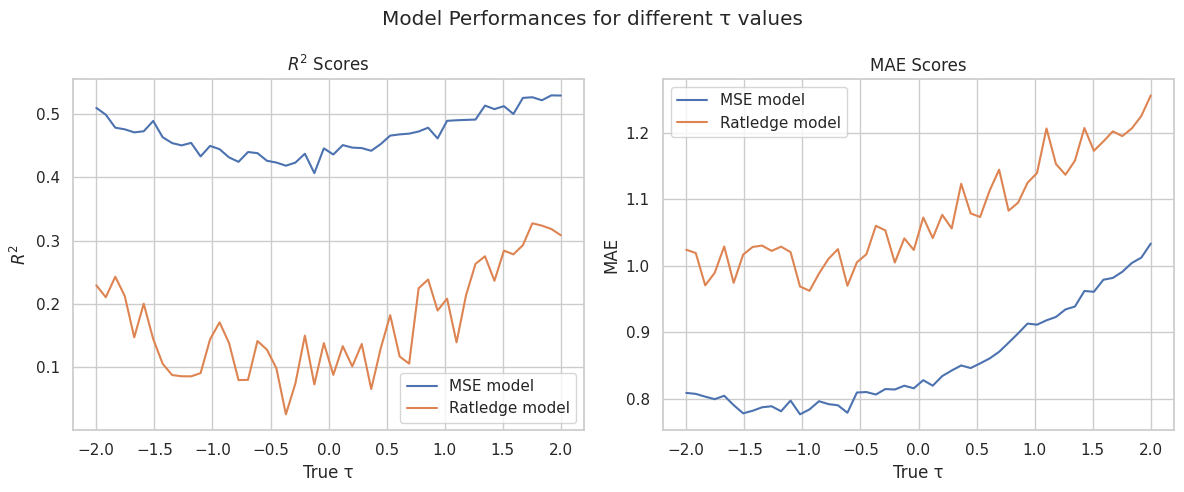

In [31]:
# Plot the R2 and MAE for both models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(taus, mse_r2s, label='MSE model')
plt.plot(taus, ratledge_r2s, label='Ratledge model')
plt.xlabel('True τ')
plt.ylabel('$R^2$')
plt.title('$R^2$ Scores')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(taus, mse_maes, label='MSE model')
plt.plot(taus, ratledge_maes, label='Ratledge model')
plt.xlabel('True τ')
plt.ylabel('MAE')
plt.title('MAE Scores')
plt.suptitle('Model Performances for different τ values')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
from scipy.stats import f
from sklearn.linear_model import LinearRegression

def f_statistic(X, Y):

    n = len(Y)

    # Restricted model: Y = X (slope fixed at 1, intercept fixed at 0)
    RSS_R = np.sum((Y - X)**2)

    # Unrestricted model: Estimate slope (k) and intercept (m)
    reg = LinearRegression()
    reg.fit(X.reshape(-1, 1), Y)
    fitted_Y = reg.predict(X.reshape(-1, 1))
    RSS_UR = np.sum((Y - fitted_Y)**2)

    # 3. Compute the F statistic
    q = 2  # number of restrictions: m=0 and k=1
    p = 2  # parameters in unrestricted model
    F_stat = ((RSS_R - RSS_UR) / q) / (RSS_UR / (n - p))

    # Compute the p-value for the F-test
    p_value = 1 - f.cdf(F_stat, q, n - p)

    print(f'Estimated slope (k):, {reg.coef_[0]:.4f}')
    print(f'Estimated intercept (m):, {reg.intercept_:.4f}')
    print(f'RSS of Restricted model (k=1, m=0):, {RSS_R:.4f}')
    print(f'RSS of Unrestricted model:, {RSS_UR:.4f}')
    print(f'F-statistic:, {F_stat:.4f}')
    print(f'p-value:, {p_value:.4f}')

print("F-statistic for target vs Naive taus:")
f_statistic(np.asarray(taus), np.asarray(pred_ates))
print('')
print("F-statistic for target vs Tweedie Adjusted taus:")
f_statistic(np.asarray(taus), np.asarray(corrected_pred_ates))
print('')
print("F-statistic for target vs LCC Adjusted taus:")
f_statistic(np.asarray(taus), np.asarray(km_pred_ates))
print('')
print("F-statistic for target vs Ratledge Adjusted taus:")
f_statistic(np.asarray(taus), np.asarray(ratledge_pred_ates))
print('')
print("F-statistic for target vs PPI Adjusted taus:")
f_statistic(np.asarray(taus), np.asarray(ppi_pred_ates))

F-statistic for target vs Naive taus:
Estimated slope (k):, 0.5346
Estimated intercept (m):, 0.0060
RSS of Restricted model (k=1, m=0):, 15.0865
RSS of Unrestricted model:, 0.0562
F-statistic:, 6420.4256
p-value:, 0.0000

F-statistic for target vs Tweedie Adjusted taus:
Estimated slope (k):, 0.9947
Estimated intercept (m):, -0.0093
RSS of Restricted model (k=1, m=0):, 0.1306
RSS of Unrestricted model:, 0.1243
F-statistic:, 1.2233
p-value:, 0.3033

F-statistic for target vs LCC Adjusted taus:
Estimated slope (k):, 1.0068
Estimated intercept (m):, -0.0237
RSS of Restricted model (k=1, m=0):, 0.1795
RSS of Unrestricted model:, 0.1481
F-statistic:, 5.0810
p-value:, 0.0100

F-statistic for target vs Ratledge Adjusted taus:
Estimated slope (k):, 0.8062
Estimated intercept (m):, 0.0320
RSS of Restricted model (k=1, m=0):, 4.5953
RSS of Unrestricted model:, 1.9373
F-statistic:, 32.9279
p-value:, 0.0000

F-statistic for target vs PPI Adjusted taus:
Estimated slope (k):, 0.9834
Estimated interce